# Laboratory 2.6: LOO + k-Fold Cross Validation

In this practice we will implement one of the main techniques to prevent overfitting when training a model: **cross-validation**.

In addition, we will be using the following libraries:
- Data management:
    - [numpy](https://numpy.org/)
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [matplotlib](https://matplotlib.org/)
    
### **All the things you need to do are marked by a "TODO" comment nearby. Make sure you *read carefully everything before working* and solve each point before submitting your solution.**

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import os
import sys
# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path
sys.path.insert(0, project_root)

In the following cell import the training (`training.dat`) and test (`test.dat`) dataset. We recommend you to use the `np.loadtxt()` function.

You will need to create the `X_train`, `y_train`, `X_test` and `y_test` variables. Take into account that each dataset have 10 variables, where the last one is the output variable.

In [10]:
# TODO: Load training.dat and text.dat and create X_train, y_train, X_test and y_test
train = np.loadtxt('../data/training.dat', delimiter=',')
X_train = train[:, :-1]
y_train = train[:, -1]
test = np.loadtxt('../data/test.dat', delimiter=',')
X_test = test[:,:-1]
y_test = test[:,-1]

With this data you are going to train the optimal `KNeighborsClassifier` model.

### Initial guess

As you have no idea of what the optimal value of `n_neighbors` is, trust your professors and use `n_neighbors = 4` to train your model.

In [11]:
# TODO: Train a KNeighborsClassifier model with n_neighbors=4
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

Now, calculate the accuracy of the model for the training and test sets using the `accuracy_score` function from `scikit-learn`.

In [12]:
# TODO: Calculate accuracy in training and test for KNN with k=4
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy, train = {acc_train} test = {acc_test}')

Accuracy, train = 0.84375 test = 0.785


**What is happening with this value of `n_neighbors`?**
> La accuracy en train es mayor que en train debido al overfitting, ya que hay pocos datos.

### Damage control
It seems that `n_neighbors = 4` overfits for this dataset. Let's try to correct this and use `n_neighbors = 20`

In [13]:
# TODO: Train a KNeighborsClassifier model with n_neighbors=20
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

Calculate again the accuracy of training and test sets for this model

In [14]:
# TODO: Calculate accuracy in training and test for KNN with k=20
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy, train = {acc_train} test = {acc_test}')

Accuracy, train = 0.81 test = 0.795


It seems that the accuracy of the test set has improved, but how can we be sure that `n_neighbors=20` is the optimal value?

### Obtaining optimal value for hyperparameters

We could keep trying with different values for `n_neighbors` until we find the optimal one. However, this strategy is unfeasible for real datasets. So how can we obtain a reasonable optimal value for the hyperparameters of a model?

We can leverage the power of cross-validation:

<center> <img title="5-Fold Cross-Validation " alt="cross-validation" src="https://miro.medium.com/v2/resize:fit:1200/1*AAwIlHM8TpAVe4l2FihNUQ.png"> </center>

Cross-validation give us a notion of the generalization error (i.e., test error) using parts of the training set as a validation set. This validation set is data that the trained model has not seen before, so if the model performs well in this part of the dataset it should generalize well in unseen data. However, as a fortunate partition might happen and generalization error might be underestimated, instead of using a single validation set we use K validation sets and we use the mean error in this K sets as the CV-error. This CV-error should give us a reliable estimation of the generalization error.

But, how can we use it to obtain the optimal hyperparameters of the model? If the CV-error is an estimation of the generalization error, the hyperparameter values with least CV-error would result in the least generalization error. As CV-error can be computed during training, we obtain a faster way to obtain the optimal values of the hyperparameters.

Now that we know why we want cross validation, implement the `cross_validation` function. This function shall implement two cross validation methods:
- K-Fold cross validation
- Leave-one-out cross validation

Check this [link](https://machinelearningmastery.com/k-fold-cross-validation/) to know the details of each method.

In [15]:
from src.Lab2_6_CV import cross_validation

Now that we have the `cross_validation` function implemented, let's check which is the optimal value for `n_neighbors` in this problem.

Optimal value of k: 9 with a score of 0.81


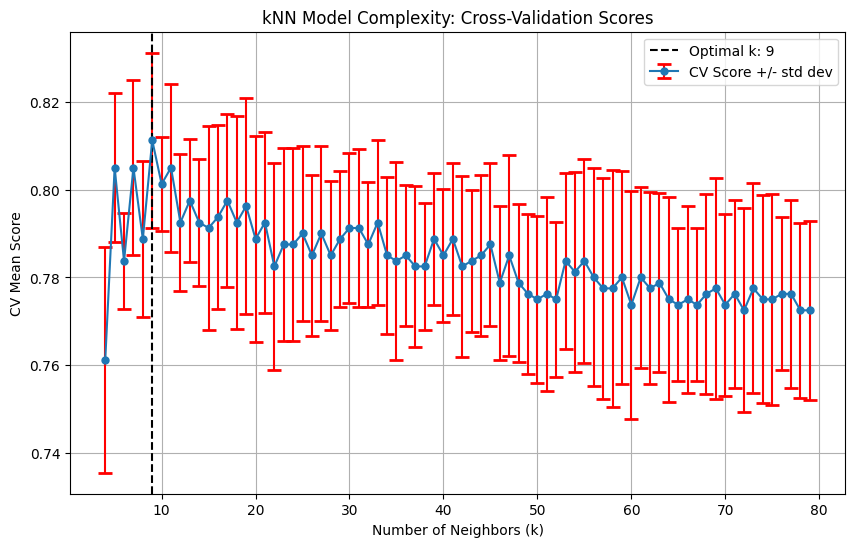

In [16]:
# Initialize lists to store mean scores and standard deviations for each value of k
mean_scores = []
std_scores = []

# Define the range of k values to test
k_values = range(4, 80)

# TODO: Loop through each value of k, obtaining the mean accuracy score and the standard deviation of the accuracy score in cross validation
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    # Ponemos nFolds = 5 por la imagen
    mean, std = cross_validation(model, X_train, y_train, nFolds=5)
    mean_scores.append(mean)
    std_scores.append(std)

# TODO: Find the highest score and the corresponding optimal k
highest_score = max(mean_scores)
optimal_k = k_values[np.argmax(mean_scores)]

print(f"Optimal value of k: {optimal_k} with a score of {highest_score:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_k, linestyle='--', color='k', label=f'Optimal k: {optimal_k}')

plt.title('kNN Model Complexity: Cross-Validation Scores')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Now that we know the optimal value for `n_neighbors`, let's train a KNN model with this value of hyperparameter and check if the generalization error has improved.

In [17]:
# TODO: Train model with k=optimal_k
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [18]:
# TODO: Calculate accuracy in training and test for KNN with k=optimal_k
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy, train = {acc_train} test = {acc_test}')

Accuracy, train = 0.84125 test = 0.815


### Sensitivity analysis
- Does the number of folds affects the optimal value of `n_neighbors`? Why or why not?
> El número de folds afecta al número optimo de n_neighbors, pues si se toma un valor k muy pequeño, la varianza del resultado aumenta, mientras que si es un valor alto, entonces el modelo será más estable.

- What happens with the computational time if you increment the number of folds?
> Cuando se aumenta k el tiempo computacional aumenta, ya que tiene que comprobarse para un mayor número de train y test.

- Does it worth to increase the number of folds? Is the CV error a better proxy of the test set?
> Aumentar el número de folds es rentable hasta un punto en el que a partir del cual solo conlleva un mayor tiempo computacional sin dar resultado. Aún así en general cuanto mayor sea el número de folds, mejor será la estimación, siendo LOO el mejor pero más caro para ello.